In [10]:
# If needed, install packages right in the notebook (uncomment as needed)
# !pip install numpy pyarrow matplotlib
# PyROOT typically comes from your environment (e.g. conda/mamba or a CERN image).
# If PyROOT isn't present, install a ROOT-enabled environment before running.


In [23]:
# !pip install numpy pyarrow matplotlib

import glob, os, numpy as np, pyarrow.parquet as pq
import matplotlib.pyplot as plt

import ROOT
ROOT.gROOT.SetBatch(True)
ROOT.TH1.AddDirectory(False)


In [25]:
def read_column_from_parquets(paths, col):
    arrs = []
    for p in paths:
        cols = set(pq.read_schema(p).names)
        if col not in cols:
            raise KeyError(f"{col} not in {p} (has: {sorted(cols)[:8]} ...)")
        arrs.append(pq.read_table(p, columns=[col]).to_pandas()[col].to_numpy("f8"))
    return np.concatenate(arrs) if arrs else np.array([], dtype="f8")

def read_optional_column(paths, col):
    """Return concatenated column if present in ALL files; else return None."""
    arrs = []
    for p in paths:
        cols = set(pq.read_schema(p).names)
        if col in cols:
            arrs.append(pq.read_table(p, columns=[col]).to_pandas()[col].to_numpy("f8"))
        else:
            arrs.append(None)
    if not arrs or any(a is None for a in arrs):
        return None
    return np.concatenate(arrs)


In [26]:
def make_hist(vals, weights=None, nbins=50, lo=-0.98, hi=1.0, name="h", unit_area=True):
    h = ROOT.TH1F(name, f";#gamma MVA ID;A.U.", nbins, lo, hi)
    h.Sumw2()
    vals = np.asarray(vals, dtype="f8")
    mask = np.isfinite(vals)
    vals = vals[mask]
    if weights is None:
        w = np.ones_like(vals, dtype="f8")
    else:
        w = np.asarray(weights, dtype="f8")[mask]
        w = np.where(np.isfinite(w), w, 0.0)

    counts, edges = np.histogram(vals, bins=nbins, range=(lo, hi), weights=w)
    errs2, _     = np.histogram(vals, bins=edges, weights=w**2)
    for i in range(1, nbins+1):
        h.SetBinContent(i, float(counts[i-1]))
        h.SetBinError(i, float(np.sqrt(errs2[i-1])))

    if unit_area and h.Integral() > 0:
        h.Scale(1.0 / h.Integral())
    return h

def hist_to_arrays(h):
    nb = h.GetNbinsX()
    x = np.array([h.GetBinCenter(i) for i in range(1, nb+1)], dtype="f8")
    y = np.array([h.GetBinContent(i) for i in range(1, nb+1)], dtype="f8")
    e = np.array([h.GetBinError(i)   for i in range(1, nb+1)], dtype="f8")
    return x, y, e

def fit_hist(h, fit_rng=(-0.95, 0.98), model="expo(0)+pol2(2)", use_likelihood=False):
    f = ROOT.TF1("f_"+h.GetName(), model, fit_rng[0], fit_rng[1])
    # robust-ish seeds
    f.SetParameters(np.log(max(h.GetBinContent(1), 1e-6)), -3.0, 0.0, 0.1, 0.0)
    opts = "RSQ" if not use_likelihood else "RSLQ"  # L = likelihood
    h.Fit(f, opts)
    return f

def draw_with_pull(ax_top, ax_bot, h, f, title):
    x, y, e = hist_to_arrays(h)
    ax_top.errorbar(x, y, yerr=e, fmt="D", ms=4, lw=1, color="k", label=r"$\gamma$ MVA IDs")
    xs = np.linspace(h.GetXaxis().GetXmin(), h.GetXaxis().GetXmax(), 400)
    ys = np.array([f.Eval(xv) for xv in xs], dtype="f8")
    ax_top.plot(xs, ys, lw=2, label="PDF")
    ax_top.set_title(title); ax_top.set_ylabel("A.U."); ax_top.legend(frameon=False, loc="upper right")

    fbin = np.array([f.Eval(xv) for xv in x], dtype="f8")
    with np.errstate(divide='ignore', invalid='ignore'):
        pull = (y - fbin) / np.where(e>0, e, np.inf)
    ax_bot.axhline(0.0, lw=1, color="gray")
    ax_bot.plot(x, pull, lw=1.5)
    ax_bot.set_xlabel(r"$\gamma$ MVA ID"); ax_bot.set_ylabel("Pull")
    ax_bot.set_ylim(-3.0, 3.0); ax_bot.grid(True, alpha=0.3)


In [44]:
# -------- inputs --------
inputs = [
    "../../output_root/v3_production/samples/postEE/QCD_PT-40ToInf.parquet",
    # "QCD_PT-*.parquet",
]
# inputs = sorted(glob.glob("QCD_PT-*.parquet")) + [
    # "DDQCDGJET_Rescaled.parquet",
# ]
assert len(inputs) > 0, "No parquet inputs found. Fill `inputs` above."

# -------- which MVA columns to use --------
mva_version = "run3"    # "run3" | "legacy" | "nano"
# "legacy"   -> uses lead_mvaID / sublead_mvaID
# "nano"     -> uses lead_mvaID_nano / sublead_mvaID_nano
# "run3"     -> uses lead_mvaID_run3 / sublead_mvaID_run3

# -------- which derived variable to plot --------
var_mode = "low"        # "lead" | "sublead" | "max" | "low"
# "low" = min(lead, sublead); "max" = max(lead, sublead)

# -------- EB/EE policy for splitting the plot --------
eb_policy = "owner"     # "owner" | "either" | "both"
# "owner": use EB/EE of whichever photon provides the value (best for 'low'/'max')
# "either": EB if (leadEB==1 or subEB==1), else EE (for candidate-level EB)
# "both": EB if (leadEB==1 and subEB==1), EE if both are EE, else drop

# -------- weights & plotting --------
use_weights = True       # if False, unit weights
nbins, lo, hi = 50, -0.98, 1.0
fit_model = "expo(0)+pol2(2)"
fit_range = (-0.95, 0.98)
use_likelihood_fit = False
unit_area = True         # normalize histogram to integral=1
out_prefix = "fit_fakegamma_mvaid"  # files saved only if you run the 'save' cell


In [45]:
# --- choose the mva columns ---
if mva_version == "run3":
    lead_col, sub_col = "lead_mvaID_run3", "sublead_mvaID_run3"
elif mva_version == "nano":
    lead_col, sub_col = "lead_mvaID_nano", "sublead_mvaID_nano"
elif mva_version == "legacy":
    lead_col, sub_col = "lead_mvaID", "sublead_mvaID"
else:
    raise ValueError("mva_version must be one of: run3 | nano | legacy")

lead_mva = read_column_from_parquets(inputs, lead_col)
sub_mva  = read_column_from_parquets(inputs, sub_col)

# EB flags (optional)
leadEB = read_optional_column(inputs, "lead_isScEtaEB")
subEB  = read_optional_column(inputs, "sublead_isScEtaEB")

# weights (optional)
weights = read_optional_column(inputs, "weight") if use_weights else None

# --- choose the variable to analyze ---
if var_mode == "lead":
    mva = lead_mva
    owner_is_lead = np.ones_like(mva, dtype=bool)
elif var_mode == "sublead":
    mva = sub_mva
    owner_is_lead = np.zeros_like(mva, dtype=bool)
elif var_mode == "max":
    owner_is_lead = (lead_mva >= sub_mva)  # ties -> lead
    mva = np.maximum(lead_mva, sub_mva)
elif var_mode == "low":
    owner_is_lead = (lead_mva <= sub_mva)  # ties -> lead
    mva = np.minimum(lead_mva, sub_mva)
else:
    raise ValueError("var_mode must be one of: lead | sublead | max | low")

# --- EB/EE masks according to policy ---
# default: all EB, none EE if EB flags missing
if leadEB is None or subEB is None:
    eb_mask = np.ones_like(mva, dtype=bool)
    ee_mask = np.zeros_like(mva, dtype=bool)
else:
    if eb_policy == "owner":
        # use EB/EE of the photon that 'owns' the mva value
        eb_mask = np.where(owner_is_lead, (leadEB == 1), (subEB == 1))
        ee_mask = np.where(owner_is_lead, (leadEB == 0), (subEB == 0))
    elif eb_policy == "either":
        eb_mask = (leadEB == 1) | (subEB == 1)
        ee_mask = (leadEB == 0) & (subEB == 0)
    elif eb_policy == "both":
        eb_mask = (leadEB == 1) & (subEB == 1)
        ee_mask = (leadEB == 0) & (subEB == 0)
        # mixed EB/EE events are dropped from both masks
    else:
        raise ValueError("eb_policy must be one of: owner | either | both")

def sel(vals, w, m):
    if w is None: return vals[m], None
    return vals[m], w[m]

mva_EB, w_EB = sel(mva, weights, eb_mask)
mva_EE, w_EE = sel(mva, weights, ee_mask)

print(f"N total: {len(mva)} | EB: {len(mva_EB)} | EE: {len(mva_EE)}")


N total: 712 | EB: 462 | EE: 250


/tmp/sraj/ipykernel_2060656/465097900.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


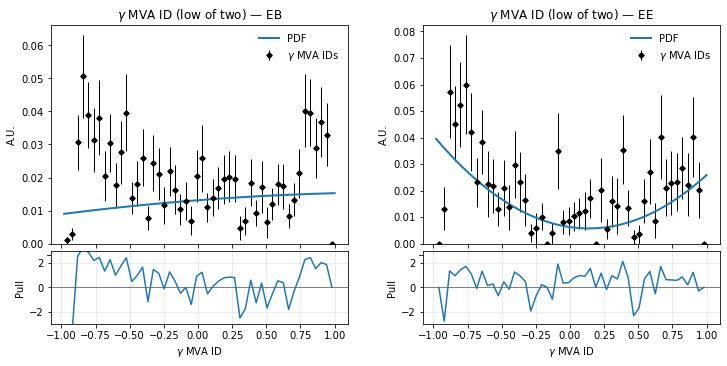

[EB] params: p0=-6.01, p1=-0.0251, p2=0.0107, p3=0.00324, p4=-0.00105
[EE] params: p0=-5.15, p1=-0.0407, p2=0.000421, p3=-0.00719, p4=0.0271


In [46]:
# Histograms
hEB = make_hist(mva_EB, weights=w_EB, nbins=nbins, lo=lo, hi=hi, name="h_EB",
                unit_area=unit_area)
hEE = make_hist(mva_EE, weights=w_EE, nbins=nbins, lo=lo, hi=hi, name="h_EE",
                unit_area=unit_area)

# Fits
fEB = fit_hist(hEB, fit_rng=fit_range, model=fit_model, use_likelihood=use_likelihood_fit)
fEE = fit_hist(hEE, fit_rng=fit_range, model=fit_model, use_likelihood=use_likelihood_fit)

# Plot (two columns: EB | EE with pull panels)
fig = plt.figure(figsize=(12, 5.5))
gs = fig.add_gridspec(2, 2, height_ratios=[3,1], hspace=0.05, wspace=0.25)

axEB_top = fig.add_subplot(gs[0,0]); axEB_bot = fig.add_subplot(gs[1,0], sharex=axEB_top)
axEE_top = fig.add_subplot(gs[0,1]); axEE_bot = fig.add_subplot(gs[1,1], sharex=axEE_top)

title_suffix = {
    "lead":"(lead)",
    "sublead":"(sublead)",
    "max":"(max of two)",
    "low":"(low of two)"
}[var_mode]

draw_with_pull(axEB_top, axEB_bot, hEB, fEB, rf"$\gamma$ MVA ID {title_suffix} — EB")
draw_with_pull(axEE_top, axEE_bot, hEE, fEE, rf"$\gamma$ MVA ID {title_suffix} — EE")
for ax in (axEB_top, axEE_top): ax.set_ylim(bottom=0)

fig.tight_layout()
plt.show()

# quick parameter printout
def p(tf1):
    return ", ".join([f"p{i}={tf1.GetParameter(i):.3g}" for i in range(tf1.GetNpar())])
print("[EB] params:", p(fEB))
print("[EE] params:", p(fEE))


In [31]:
save = True
if save:
    pdf_out = f"{out_prefix}_{var_mode}_{mva_version}.pdf"
    png_out = f"{out_prefix}_{var_mode}_{mva_version}.png"
    fig.savefig(pdf_out)
    fig.savefig(png_out, dpi=180)
    print(f"[OK] Saved plots: {pdf_out}, {png_out}")

    # ROOT file with hists + fits
    froot = ROOT.TFile(f"{out_prefix}_{var_mode}_{mva_version}.root", "RECREATE")
    hEB.Write(); hEE.Write()
    fEB.Write("f_EB"); fEE.Write("f_EE")
    froot.Close()
    print(f"[OK] Wrote ROOT objects to: {out_prefix}_{var_mode}_{mva_version}.root")


NameError: name 'var_mode' is not defined

In [43]:
import numpy as np

def frac_true(x):
    return float(np.mean(x)) if x is not None and len(x)>0 else np.nan

# Pick which MVA pair you’re using
lead = read_column_from_parquets(inputs, "lead_mvaID_run3")   # or lead_mvaID / _nano
sub  = read_column_from_parquets(inputs, "sublead_mvaID_run3")

# Working-point flags (booleans 0/1)
wp90L = read_optional_column(inputs, "lead_mvaID_WP90")
wp90S = read_optional_column(inputs, "sublead_mvaID_WP90")
wp80L = read_optional_column(inputs, "lead_mvaID_WP80")
wp80S = read_optional_column(inputs, "sublead_mvaID_WP80")

# Gen-flavour (1 = prompt in NanoAOD; fakes usually 0 or missing)
gflL = read_optional_column(inputs, "lead_genPartFlav")
gflS = read_optional_column(inputs, "sublead_genPartFlav")

print("N events:", len(lead))
print("Quantiles lead:", np.quantile(lead, [0, .1, .5, .9, 1]))
print("Quantiles sub :", np.quantile(sub , [0, .1, .5, .9, 1]))
print("Frac WP90 lead/sub:", frac_true(wp90L), frac_true(wp90S))
print("Frac WP80 lead/sub:", frac_true(wp80L), frac_true(wp80S))
print("Prompt fraction lead/sub (genPartFlav==1):",
      np.mean(gflL==1) if gflL is not None else np.nan,
      np.mean(gflS==1) if gflS is not None else np.nan)


N events: 48
Quantiles lead: [-0.87675607 -0.66994995  0.37874842  0.91002343  0.94664848]
Quantiles sub : [-0.88419461 -0.64667695  0.61302769  0.92126505  0.95527506]
Frac WP90 lead/sub: 0.625 0.6666666666666666
Frac WP80 lead/sub: 0.4583333333333333 0.5625
Prompt fraction lead/sub (genPartFlav==1): 0.3125 0.4791666666666667


In [36]:
#Recheck

N after fake selection: 23 (kept 0.0% of original)


/tmp/sraj/ipykernel_2060656/2266383399.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); plt.show()


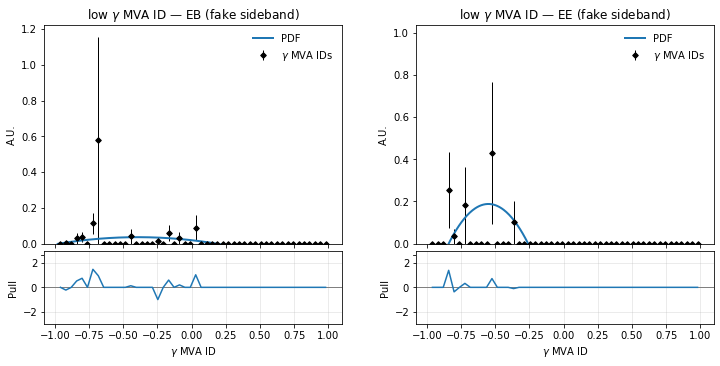

In [38]:
# --- load columns you already inspected ---
lead = read_column_from_parquets(inputs, "lead_mvaID_run3")   # or lead_mvaID/_nano if that's your era
sub  = read_column_from_parquets(inputs, "sublead_mvaID_run3")

wp90L = read_optional_column(inputs, "lead_mvaID_WP90")
wp90S = read_optional_column(inputs, "sublead_mvaID_WP90")
wp80L = read_optional_column(inputs, "lead_mvaID_WP80")
wp80S = read_optional_column(inputs, "sublead_mvaID_WP80")

gflL  = read_optional_column(inputs, "lead_genPartFlav")   # MC only
gflS  = read_optional_column(inputs, "sublead_genPartFlav")

leadEB = read_optional_column(inputs, "lead_isScEtaEB")
subEB  = read_optional_column(inputs, "sublead_isScEtaEB")

weights = read_optional_column(inputs, "weight")  # or None for unit weights

# -------------------------------
# 1) Define a FAKE-γ sideband mask
# -------------------------------
# Option A: Anti-ID (fail WP90). This is the typical data-driven sideband.
antiID = np.ones_like(lead, dtype=bool)
if (wp90L is not None) and (wp90S is not None):
    # at least one photon fails WP90 → jet-enriched
    antiID = (wp90L == 0) | (wp90S == 0)
elif (wp80L is not None) and (wp80S is not None):
    antiID = (wp80L == 0) | (wp80S == 0)
else:
    # fallback numeric anti-cut if no WP branches exist (tune threshold to your note)
    antiID = (lead < 0.2) | (sub < 0.2)

# Option B: Gen-level veto (MC only). Turn on if you’re validating with MC.
use_gen_veto = True   # set False for data
if use_gen_veto and (gflL is not None) and (gflS is not None):
    not_prompt = (gflL != 1) & (gflS != 1)
else:
    not_prompt = np.ones_like(lead, dtype=bool)

mask_fake = antiID & not_prompt

# Apply mask
lead_sel = lead[mask_fake]
sub_sel  = sub [mask_fake]
w_sel    = None if weights is None else weights[mask_fake]
leadEB_sel = None if leadEB is None else (leadEB[mask_fake] == 1)
subEB_sel  = None if subEB  is None else (subEB [mask_fake] == 1)

print(f"N after fake selection: {len(lead_sel)} "
      f"(kept {100*len(lead_sel)/len(lead):.1f}% of original)")

# -----------------------------------------
# 2) Build LOW γ MVA ID and EB/EE by owner
# -----------------------------------------
low = np.minimum(lead_sel, sub_sel)
owner_is_lead = (lead_sel <= sub_sel)  # ties -> lead

if (leadEB_sel is not None) and (subEB_sel is not None):
    low_isEB = np.where(owner_is_lead, leadEB_sel, subEB_sel)
    low_isEE = ~low_isEB
else:
    # EB/EE split not possible — make inclusive EB-only plot
    low_isEB = np.ones_like(low, bool)
    low_isEE = np.zeros_like(low, bool)

# -----------------------------------------
# 3) Make histograms, fit, and plot w/ pulls
# -----------------------------------------
nbins, lo, hi = 50, -0.98, 1.0
hEB = make_hist(low[low_isEB], weights=None if w_sel is None else w_sel[low_isEB],
                nbins=nbins, lo=lo, hi=hi, name="h_low_EB", unit_area=True)
hEE = make_hist(low[low_isEE], weights=None if w_sel is None else w_sel[low_isEE],
                nbins=nbins, lo=lo, hi=hi, name="h_low_EE", unit_area=True)

fEB = fit_hist(hEB, model="expo(0)+pol2(2)", fit_rng=(-0.95, 0.98))
fEE = fit_hist(hEE, model="expo(0)+pol2(2)", fit_rng=(-0.95, 0.98))

fig = plt.figure(figsize=(12,5.5))
gs = fig.add_gridspec(2,2, height_ratios=[3,1], hspace=0.05, wspace=0.25)
a1 = fig.add_subplot(gs[0,0]); b1 = fig.add_subplot(gs[1,0], sharex=a1)
a2 = fig.add_subplot(gs[0,1]); b2 = fig.add_subplot(gs[1,1], sharex=a2)
draw_with_pull(a1, b1, hEB, fEB, r"low $\gamma$ MVA ID — EB (fake sideband)")
draw_with_pull(a2, b2, hEE, fEE, r"low $\gamma$ MVA ID — EE (fake sideband)")
for ax in (a1,a2): ax.set_ylim(bottom=0)
fig.tight_layout(); plt.show()


In [39]:
total = len(lead)
anti_only = np.sum(antiID)
gen_veto_only = np.sum(not_prompt)
both = np.sum(mask_fake)

print(f"Total events: {total}")
print(f"After anti-ID only: {anti_only} ({100*anti_only/total:.2f}%)")
print(f"After gen-veto only: {gen_veto_only} ({100*gen_veto_only/total:.2f}%)")
print(f"After both: {both} ({100*both/total:.2f}%)")


Total events: 3255690
After anti-ID only: 379746 (11.66%)
After gen-veto only: 40 (0.00%)
After both: 23 (0.00%)


N fake-sideband events: 376 (52.81% of original)


/tmp/sraj/ipykernel_2060656/29693569.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(); plt.show()


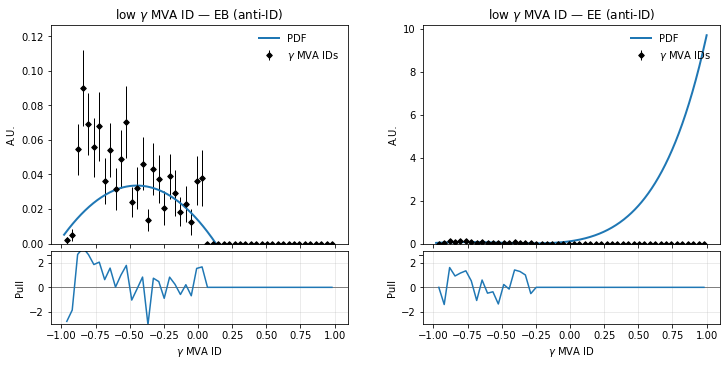

In [47]:
# --- load the columns (adjust *_run3 -> your era if needed) ---
lead = read_column_from_parquets(inputs, "lead_mvaID_run3")
sub  = read_column_from_parquets(inputs, "sublead_mvaID_run3")

wp90L = read_optional_column(inputs, "lead_mvaID_WP90")
wp90S = read_optional_column(inputs, "sublead_mvaID_WP90")
wp80L = read_optional_column(inputs, "lead_mvaID_WP80")
wp80S = read_optional_column(inputs, "sublead_mvaID_WP80")

leadEB = read_optional_column(inputs, "lead_isScEtaEB")
subEB  = read_optional_column(inputs, "sublead_isScEtaEB")
weights = read_optional_column(inputs, "weight")  # or set to None for unit weights

# 1) FAKE sideband = Anti-ID only (no gen veto)
if (wp90L is not None) and (wp90S is not None):
    antiID = (wp90L == 0) | (wp90S == 0)   # fail WP90
elif (wp80L is not None) and (wp80S is not None):
    antiID = (wp80L == 0) | (wp80S == 0)   # fallback: fail WP80
else:
    antiID = (lead < 0.2) | (sub < 0.2)    # numeric fallback; tune threshold to your note

mask = antiID

# Apply mask
lead_sel = lead[mask]
sub_sel  = sub [mask]
w_sel    = None if weights is None else weights[mask]
leadEB_sel = None if leadEB is None else (leadEB[mask] == 1)
subEB_sel  = None if subEB  is None else (subEB [mask] == 1)

print(f"N fake-sideband events: {len(lead_sel)} "
      f"({100*len(lead_sel)/len(lead):.2f}% of original)")

# 2) LOW γ MVA ID and EB/EE by owner
low = np.minimum(lead_sel, sub_sel)
owner_is_lead = (lead_sel <= sub_sel)  # ties -> lead

if (leadEB_sel is not None) and (subEB_sel is not None):
    low_isEB = np.where(owner_is_lead, leadEB_sel, subEB_sel)
    low_isEE = ~low_isEB
else:
    low_isEB = np.ones_like(low, bool); low_isEE = np.zeros_like(low, bool)

# 3) Make histograms, fit, and plot
nbins, lo, hi = 50, -0.98, 1.0
hEB = make_hist(low[low_isEB], weights=None if w_sel is None else w_sel[low_isEB],
                nbins=nbins, lo=lo, hi=hi, name="h_low_EB", unit_area=True)
hEE = make_hist(low[low_isEE], weights=None if w_sel is None else w_sel[low_isEE],
                nbins=nbins, lo=lo, hi=hi, name="h_low_EE", unit_area=True)

fEB = fit_hist(hEB, model="expo(0)+pol2(2)", fit_rng=(-0.95, 0.98))
fEE = fit_hist(hEE, model="expo(0)+pol2(2)", fit_rng=(-0.95, 0.98))

fig = plt.figure(figsize=(12,5.5))
gs = fig.add_gridspec(2,2, height_ratios=[3,1], hspace=0.05, wspace=0.25)
a1 = fig.add_subplot(gs[0,0]); b1 = fig.add_subplot(gs[1,0], sharex=a1)
a2 = fig.add_subplot(gs[0,1]); b2 = fig.add_subplot(gs[1,1], sharex=a2)
draw_with_pull(a1, b1, hEB, fEB, r"low $\gamma$ MVA ID — EB (anti-ID)")
draw_with_pull(a2, b2, hEE, fEE, r"low $\gamma$ MVA ID — EE (anti-ID)")
for ax in (a1,a2): ax.set_ylim(bottom=0)
fig.tight_layout(); plt.show()


In [48]:
import os, glob, re, pyarrow.parquet as pq

# ---- pick your era dir ----
BASE = "../../output_root/v3_production/samples"
ERA  = "postEE"          # change to "preEE" if needed

# ---- grab QCD parquet files in that dir ----
all_qcd = sorted(glob.glob(os.path.join(BASE, ERA, "QCD_PT-*.parquet")))
assert all_qcd, f"No QCD parquet files found under {os.path.join(BASE, ERA)}"

# ---- avoid double counting from overlapping ranges ----
# We'll keep either the explicit bins (e.g. 30To40 + 40ToInf) OR a single inclusive "*ToInf".
# Preference order:
#   1) If there is any "*ToInf" file, keep ONLY the *lowest* threshold ToInf (e.g. 30ToInf), drop others & all narrower bins.
#   2) Otherwise, keep all explicit non-overlapping bins (e.g. 30To40, 40ToInf, ...).

def parse_range(fname):
    """Return (lo, hi) from 'QCD_PT-<lo>To<hi>.parquet', with hi=None for 'Inf'."""
    m = re.search(r"QCD_PT-(\d+)To(Inf|\d+)\.parquet$", os.path.basename(fname))
    if not m: return None, None
    lo = int(m.group(1))
    hi = None if m.group(2) == "Inf" else int(m.group(2))
    return lo, hi

ranges = [(f, *parse_range(f)) for f in all_qcd if parse_range(f) != (None, None)]
toinf  = [(f, lo) for (f, lo, hi) in ranges if hi is None]

if toinf:
    # keep only the *lowest* ToInf (most inclusive), drop everything else
    keep_lo, keep_file = min((lo, f) for (f, lo) in toinf)
    inputs = [keep_file]
    dropped = [f for (f,lo,hi) in ranges if f != keep_file]
else:
    # keep all explicit bins (no overlaps expected in these)
    inputs = [f for (f,lo,hi) in ranges]
    dropped = []

print("Selected QCD inputs:")
for f in inputs:
    lo, hi = parse_range(f)
    print(f"  - {os.path.basename(f):<28}  range: {lo} → {('Inf' if hi is None else hi)}")

if dropped:
    print("\nDropped to avoid overlap:")
    for f in dropped:
        print("  -", os.path.basename(f))

# Quick row-count + schema check for key columns
need_cols = ["lead_mvaID_run3", "sublead_mvaID_run3", "lead_isScEtaEB", "sublead_isScEtaEB", "weight",
             "lead_mvaID_WP90", "sublead_mvaID_WP90", "lead_mvaID_WP80", "sublead_mvaID_WP80"]
print("\nFile sanity summary:")
for f in inputs:
    md = pq.read_metadata(f)
    nrows = md.num_rows
    cols  = set(pq.read_schema(f).names)
    missing = [c for c in need_cols if c not in cols]
    print(f"  {os.path.basename(f):<28} rows={nrows:,}  missing={missing if missing else 'OK'}")

assert len(inputs) > 0, "No parquet inputs selected."


Selected QCD inputs:
  - QCD_PT-30ToInf.parquet        range: 30 → Inf

Dropped to avoid overlap:
  - QCD_PT-30To40.parquet
  - QCD_PT-40ToInf.parquet

File sanity summary:
  QCD_PT-30ToInf.parquet       rows=35  missing=OK
